In [1]:
from __future__ import annotations

import os
from dotenv import load_dotenv
from dataclasses import dataclass
from typing import Tuple, Dict, Optional
from stonks.data_preprocessing import Client

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
load_dotenv()
API_KEY = os.getenv("POLYGON_API_KEY")
client = Client(API_KEY)

In [3]:
%load_ext autoreload
%autoreload 2

ticker = "VOO"
historical_stock_data = client.get_price_history(ticker)

In [4]:
historical_stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   volume     500 non-null    float64       
 1   vw         500 non-null    float64       
 2   open       500 non-null    float64       
 3   close      500 non-null    float64       
 4   high       500 non-null    float64       
 5   low        500 non-null    float64       
 6   timestamp  500 non-null    datetime64[ns]
 7   n          500 non-null    int64         
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 31.4 KB


## Data Processing
Below we load in 2 years worth of weekly stock returns for VOO. Note that while we will probably (definitely) need more data, this just serves as a starting point. Additionally, we look at the log of the returns so that we can take advantage of the additive properties of logarithms and avoid directional bias with percent returns

In [5]:
def prepare_weekly_returns(
    df: pd.DataFrame,
    price_col: str = "close",
    ts_col: str = "timestamp",
    k: int = 5,
) -> pd.DataFrame:
    """
    Overlapping (rolling) k-trading-session 'weekly' returns.

    For each trading day t (starting from the k-th), compute:
        log_ret_t = log(price_t) - log(price_{t-k})
    and flag an event if the corresponding simple return <= -10%
        ⇔ log_ret_t <= ln(0.9).

    This generalizes Mon→Fri, Tue→Mon, Wed→Tue, ... without manual rotation.
    Weekends/holidays simply expand the calendar span of the window; the count
    is in trading sessions.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain [ts_col, price_col]. `ts_col` must be datetime64[ns].
    price_col : str, default "close"
        Price used for returns.
    ts_col : str, default "timestamp"
        Timestamp column name (datetime64[ns]).
    k : int, default 5
        Number of trading sessions per 'week' window.

    Returns
    -------
    pd.DataFrame
        Index: trading date (window end).
        Columns:
          - price   : price at the window end date
          - log_ret : k-session log return ending at the index date
          - event   : 1 if simple return over the window <= -10%, else 0
    """
    if not np.issubdtype(df[ts_col].dtype, np.datetime64):
        raise TypeError(f"{ts_col} must be datetime64[ns].")

    # One row per trading date (e.g., last available close per date)
    d = (
        df[[ts_col, price_col]]
        .dropna(subset=[price_col])
        .sort_values(ts_col)
        .assign(date=lambda x: x[ts_col].dt.normalize())
    )
    daily = d.groupby("date", sort=True)[price_col].last().to_frame("price")

    if len(daily) < k + 1:
        raise ValueError(
            f"Need at least {k + 1} trading days to compute overlapping {k}-day returns."
        )

    # Overlapping k-session log return: log P_t - log P_{t-k}
    log_price = np.log(daily["price"])
    daily["log_ret"] = log_price - log_price.shift(k)

    # Event: <= -10% simple return ↔ log_ret <= ln(0.9)
    threshold = float(np.log(0.95)) #ln(.95) is about -5%, just testing for other purposes
    daily["event"] = (daily["log_ret"] <= threshold).astype(int)

    # Drop the first k rows (no prior window)
    out = daily.dropna(subset=["log_ret"])
    out.index.name = "block_end"
    return out

weekly = prepare_weekly_returns(historical_stock_data)
weekly.tail()

,price,log_ret,event
block_end,,,
2025-09-16,606.79,0.014676,0
2025-09-17,606.09,0.010632,0
2025-09-18,608.94,0.007202,0
2025-09-19,611.78,0.012070,0
2025-09-22,614.76,0.011732,0


In [6]:
sum(weekly['event'] == 1)

6

## Survival Analysis
From above, we see that there have been 6 periods that have had a 5 day trading period with a -5% drawdown. Now we begin the survival analysis.

1. **Right-Spelled Spell Length** : The observation period (i.e. each rolling 5 day period) ends before the -5% (or X% drawdown occurs). The "spell" refers to an event not occurring yet and the data is censored since we only know a lower bound for the duration between X% drawdowns (i.e. the time between the last and today).

In [29]:
@dataclass
class DurationData:
    """Inter-event durations for survival/hazard models."""
    durations: np.ndarray          # completed spells that end with an event
    censored: Optional[float]  

def thin_events_with_refractory(
    event_s: pd.Series,
    refractory: int,
    *,
    name: str = "event_first_hit",
) -> pd.Series:
    """
    Keep the first '1' then force the next `refractory` observations to 0.
    Use `refractory = k_window - 1` for k-session overlapping windows.

    Parameters
    ----------
    event_s : pd.Series
        Binary series (1=event, 0=none), chronological, fixed step.
    refractory : int
        Non-negative cooldown length after a hit.

    Returns
    -------
    pd.Series
        Thinned binary series with the same index.
    """
    if refractory is None or refractory < 0:
        raise ValueError("refractory must be a non-negative integer")

    # Treat NaN as no event; ensure int 0/1
    ev = event_s.fillna(0).astype(int).values
    keep = np.zeros_like(ev)
    cooldown = 0

    for i, v in enumerate(ev):
        if cooldown > 0:
            cooldown -= 1
            continue
        if v == 1:
            keep[i] = 1
            cooldown = int(refractory)

    return pd.Series(keep, index=event_s.index, name=name)


def durations_from_events(event_series: pd.Series) -> DurationData:
    """
    Convert a binary event series to completed inter-event durations and a final right-censored spell.

    Parameters
    ----------
    event_series : pd.Series
        1 for event, 0 otherwise; chronological; fixed step (sessions or weeks).

    Returns
    -------
    DurationData
        durations : np.ndarray of completed spell lengths (float)
        censored  : float length of the final ongoing spell, or None
    """
    s = event_series.copy()
    if not s.index.is_monotonic_increasing:
        s = s.sort_index()
    s = s.fillna(0).astype(int)

    durs: list[float] = []
    current = 0
    for v in s.values:
        current += 1
        if v == 1:
            durs.append(float(current))
            current = 0

    censored = float(current) if current > 0 else None
    return DurationData(durations=np.asarray(durs, dtype=float), censored=censored)


def build_durations_for_survival(
    overlapping_events: pd.Series,
    k_window: int = 5,
) -> tuple[pd.Series, DurationData]:
    """
    Thin overlapping events to first hits, then compute DurationData.

    Parameters
    ----------
    overlapping_events : pd.Series
        Raw overlapping event flags (e.g., from 5-session rolling returns).
    k_window : int, default 5
        Window length used to define the overlapping events.

    Returns
    -------
    (event_first_hit, DurationData)
    """
    event_first_hit = thin_events_with_refractory(
        overlapping_events, refractory=k_window - 1
    )
    dur = durations_from_events(event_first_hit)
    return event_first_hit, dur

K_WINDOW = 5  # sessions per overlapping window
event_first_hit, dur = build_durations_for_survival(weekly["event"], k_window=K_WINDOW)
event_first_hit.tail()

block_end
2025-09-16    0
2025-09-17    0
2025-09-18    0
2025-09-19    0
2025-09-22    0
Name: event_first_hit, dtype: int64

In [31]:
n_steps = len(weekly)
n_events_thin = int(event_first_hit.sum())
assert n_steps == int(dur.durations.sum() + (dur.censored or 0.0))
n_events_thin

2

In [32]:
len(dur.durations)

2

## Calibration of priors from Empirical Tail Frequency
The goal here is simple, use "Extreme Value Theory" (EVT) to focus on the frequency of events in the tails of a distribution. The output is just the frequency of an X% drawdown.
**Note:** An improvement here could be fitting some sort of distribution to our data. 

In [33]:
# We anchor a weak prior on the exponential hazard λ using observed event rate.
# If there are zero events, we use Laplace smoothing.
@dataclass
class ExponentialPrior:
    alpha: float
    beta: float  # Gamma(shape=alpha, rate=beta); mean = alpha / beta


def _thin_first_hits(event_series: pd.Series, refractory: int) -> pd.Series:
    """
    Keep only the first '1' then force the next `refractory` observations to 0.
    Use refractory = k-1 when events come from k-session overlapping windows.
    """
    ev = event_series.astype(int).values
    keep = np.zeros_like(ev)
    cooldown = 0
    for i, v in enumerate(ev):
        if cooldown > 0:
            cooldown -= 1
            continue
        if v == 1:
            keep[i] = 1
            cooldown = int(refractory)
    return pd.Series(keep, index=event_series.index, name=event_series.name)


def calibrate_exponential_prior(
    event_series: pd.Series,
    prior_strength: float = 5.0,
    dt: float = 1.0,
    *,
    thin_clusters: bool = False,
    refractory: Optional[int] = None,
) -> ExponentialPrior:
    """
    Calibrate a Gamma prior for the exponential hazard rate λ (per time step).

    Parameters
    ----------
    event_series : pd.Series
        Binary series (1=event, 0=none) at a fixed step (week, session, etc.).
        If events came from overlapping windows, consider thin_clusters=True.
    prior_strength : float, default 5.0
        Pseudo-exposure T0 in *steps*. Acts as prior weight: alpha0 = λ0 * T0, beta0 = T0.
    dt : float, default 1.0
        Length of one step in time-units you care about (usually leave at 1.0).
        λ is interpreted as "per dt".
    thin_clusters : bool, default False
        If True, convert to first-hit events using the given `refractory`.
    refractory : Optional[int]
        Number of subsequent steps to suppress after a hit (use k-1 for k-session windows).

    Returns
    -------
    ExponentialPrior
        Gamma prior on λ with mean close to the smoothed empirical rate.

    Notes
    -----
    - Smoothing: p_hat = (k + 1) / (n + 2)  (Laplace/Bayes with Beta(1,1) prior).
    - Exact mapping: λ0 = -ln(1 - p_hat) / dt (stable for small/large p).
    - With constant step size, total exposure T equals len(event_series) * dt.
    """
    s = event_series.copy()

    if thin_clusters:
        if refractory is None or refractory < 0:
            raise ValueError("Provide a non-negative 'refractory' when thin_clusters=True.")
        s = _thin_first_hits(s, refractory=refractory)

    n = int(s.shape[0]) #total number of trading sessions
    k = int(s.fillna(0).sum()) #number of events (drawdowns)

    if n <= 0:
        raise ValueError("Empty event series.")

    # Laplace-smoothed per-step event probability to avoid 0 probabilities for events that have not occurred
    p_hat = (k + 1.0) / (n + 2.0)
    # Numerical safety
    p_hat = float(np.clip(p_hat, 1e-12, 1 - 1e-12))

    # Exact probability-to-rate mapping by rearranging survival function and solving for lam0
    lam0 = -np.log(1.0 - p_hat) / float(dt) #This is put in terms of hazard rate per time unit

    # Prior as pseudo-exposure T0 = prior_strength, pseudo-events k0 = lam0 * T0
    T0 = max(1e-9, float(prior_strength))
    alpha0 = max(1e-12, lam0 * T0)
    beta0 = T0

    return ExponentialPrior(alpha=alpha0, beta=beta0)

exp_prior = calibrate_exponential_prior(
    weekly["event"],
    prior_strength=5.0,
    dt=1.0,                 # one step = one session (or one week if that's your step)
    thin_clusters=True,     # recommended for first-passage semantics
    refractory=5 - 1,       # k - 1 for k-session windows
)
exp_prior

ExponentialPrior(alpha=np.float64(0.030272544543531302), beta=5.0)

## Interpreting The Exponential Prior & Modeling
The exponential prior is driven by 2 parameters: $\alpha$ and $\beta$. Note that we left $\beta$ = 5 to indicate the number of trading sessions that we are dealing with. $\alpha$ indicates the frequency of an event occuring during our 5 day trading sessions given the hazard rate.

### Model A (below) - Exponential (Constant Hazard Rate) With a Gamma Prior
1. The likelihood is exponentially distributed (specifically a Gamma distribution). The Gamma distribution is specific because it belongs to the same distribution as Poisson surival functions.
2. We assume a constant hazard rate
* This may be an errorneous assumption since it leads to a "memoryless" probability
3. Posterior: λ | data ~ Gamma(α + k, β + total_time) 
* This is a closed form estimation (k is the total observed events and total_time is the sum of all exposure we have)


In [34]:
@dataclass
class ExponentialPosterior:
    alpha: float
    beta: float

    @property
    def mean_rate(self) -> float:
        return self.alpha / self.beta

    def prob_event_next_h_weeks(self, h: float) -> float:
        """
        Predictive P(event within horizon h) given survival to now:
        1 - E[e^{-λ h}] = 1 - (beta / (beta + h))^alpha
        """
        return 1.0 - (self.beta / (self.beta + h)) ** self.alpha


def fit_exponential_posterior(
    event_series: pd.Series, prior: ExponentialPrior, durations: DurationData
) -> ExponentialPosterior:
    k = int(event_series.sum())
    total_time = durations.durations.sum() + (durations.censored or 0.0)
    alpha_post = prior.alpha + k
    beta_post = prior.beta + total_time
    return ExponentialPosterior(alpha=alpha_post, beta=beta_post)


exp_post = fit_exponential_posterior(weekly["event"], exp_prior, dur)
print(
    f"Exponential posterior mean rate (per week): {exp_post.mean_rate:.6f} "
    f"→ mean time-to-event ≈ {1.0/exp_post.mean_rate:.1f} weeks"
)

Exponential posterior mean rate (per week): 0.012061 → mean time-to-event ≈ 82.9 weeks


The following plot now shows our best estimates of have atleast one -5% drawdown over the next ~100 weeks

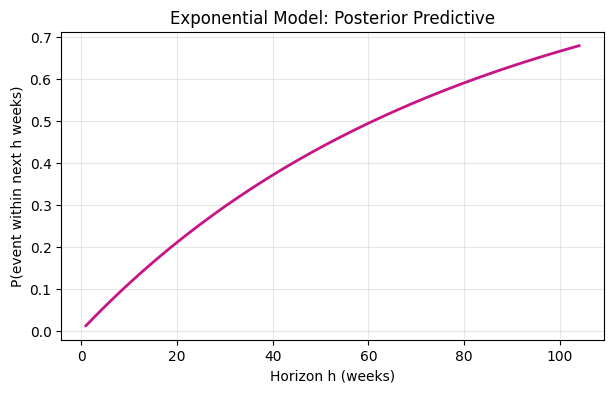

In [35]:
def plot_exponential_predictive(exp_posterior: ExponentialPosterior, h_max: int = 52) -> None:
    h_vals = np.arange(1, h_max + 1, dtype=float)
    probs = np.array([exp_posterior.prob_event_next_h_weeks(h) for h in h_vals])

    plt.figure(figsize=(7, 4))
    plt.plot(h_vals, probs, lw=2, color='mediumvioletred')
    plt.xlabel("Horizon h (weeks)")
    plt.ylabel("P(event within next h weeks)")
    plt.title("Exponential Model: Posterior Predictive")
    plt.grid(True, alpha=0.3)
    plt.show()


plot_exponential_predictive(exp_post, h_max=104)

## Weibull Distribution
The weibull distribution has two paramters: k (shape parameter) and lambda (scale parameter). More documentation can be found here (https://en.wikipedia.org/wiki/Weibull_distribution) but this distribution seems to allow for duration-dependant hazard rates so it's exactly what we need.
* Weibull(k, λ): survival S(t) = exp(-(λ t)^k). Increasing hazard if k > 1

From this we begin to compute the censored-data likelihood with a prior on (k, $\lambda$)

In [36]:
@dataclass
class WeibullPosteriorGrid:
    k_grid: np.ndarray
    lam_grid: np.ndarray
    log_post: np.ndarray  # shape (len(k_grid), len(lam_grid))


def weibull_loglik(
    durations: DurationData, k: float, lam: float
) -> float:
    """
    Right-censored log-likelihood under Weibull with scale parameterization S(t)=exp(-(lam*t)^k).

    durations.durations: completed spells (each ended by an event)
        contribution: log f(t) = log [k * lam^k * t^{k-1} * exp(-(lam t)^k)]
    durations.censored: right-censored spell
        contribution: log S(t) = -(lam * t)^k
    """
    t_e = durations.durations  # events
    ll = 0.0
    if t_e.size > 0:
        ll += t_e.size * (math.log(k) + k * math.log(lam))
        ll += (k - 1.0) * np.log(t_e).sum()
        ll += -np.power(lam * t_e, k).sum()

    if durations.censored is not None:
        t_c = durations.censored
        ll += -((lam * t_c) ** k)

    return float(ll)


def fit_weibull_grid_posterior(
    durations: DurationData,
    k_bounds: Tuple[float, float] = (0.4, 3.0),
    lam_bounds: Tuple[float, float] = (1e-3, 1.0),
    k_points: int = 120,
    lam_points: int = 160,
    prior_strength: float = 1.0,
) -> WeibullPosteriorGrid:
    """
    Grid posterior over (k, λ) with a weak prior:
    π(k, λ) ∝ 1/(k * λ)  (Jeffreys-like, improper; here made proper by grid bounds),
    then multiplied by an exponential-anchored shrink via 'prior_strength' towards small λ.

    Notes
    -----
    - If there are zero events, posterior will favor small λ and is largely driven by the censored spell.
    - Increase 'prior_strength' to avoid degenerate posteriors with very small λ.
    """
    k_grid = np.linspace(k_bounds[0], k_bounds[1], k_points)
    lam_grid = np.geomspace(lam_bounds[0], lam_bounds[1], lam_points)

    log_prior = np.zeros((k_points, lam_points), dtype=float)
    # Jeffreys-like prior ~ 1/(k*λ)  → log prior = -log k - log λ
    log_prior += -np.log(k_grid)[:, None]
    log_prior += -np.log(lam_grid)[None, :]
    # Gentle shrinkage on λ: exp(-prior_strength * λ) → add -prior_strength*λ in log, prevent from settling on extreme values
    log_prior += -prior_strength * lam_grid[None, :]

    log_like = np.zeros_like(log_prior)
    for i, k in enumerate(k_grid):
        for j, lam in enumerate(lam_grid):
            log_like[i, j] = weibull_loglik(durations, k, lam)

    # Stabilize with log-sum-exp
    log_post = log_like + log_prior
    log_post -= np.max(log_post)
    return WeibullPosteriorGrid(k_grid=k_grid, lam_grid=lam_grid, log_post=log_post)


wb_post = fit_weibull_grid_posterior(dur, prior_strength=1.0)
wb_post.log_post.shape


(120, 160)

In [37]:
def weibull_posterior_expectations(grid: WeibullPosteriorGrid) -> Dict[str, float]:
    w = np.exp(grid.log_post)
    w /= w.sum()

    k_mean = float((w * grid.k_grid[:, None]).sum())
    lam_mean = float((w * grid.lam_grid[None, :]).sum())

    # Posterior mean hazard at a given duration t (instantaneous hazard):
    # h(t) = k * λ^k * t^{k-1}
    def hazard_at(t: float) -> float:
        kt = (grid.k_grid[:, None] * (grid.lam_grid[None, :] ** grid.k_grid[:, None])
              * (t ** (grid.k_grid[:, None] - 1.0)))
        return float((w * kt).sum())

    return {"k_mean": k_mean, "lam_mean": lam_mean, "hazard_at": hazard_at}


wb_summary = weibull_posterior_expectations(wb_post)
print(
    f"Weibull posterior mean k ≈ {wb_summary['k_mean']:.3f} "
    f"(>1 implies increasing hazard)."
)


Weibull posterior mean k ≈ 1.723 (>1 implies increasing hazard).


Since we scanned over a grid of k values to estimate an unkown value (k), we take the mean of the posterior distribution (according to Bayes estimates). We can now look at the probability of an event occuring within h days. 

**Posterior Mass** : indicates the probability of our model when integrating through a region of space after introducing our data.

This really just indicates where we need to look at the area under the curve as this gives the most probable rate for an event to occur in a 5 trading day session

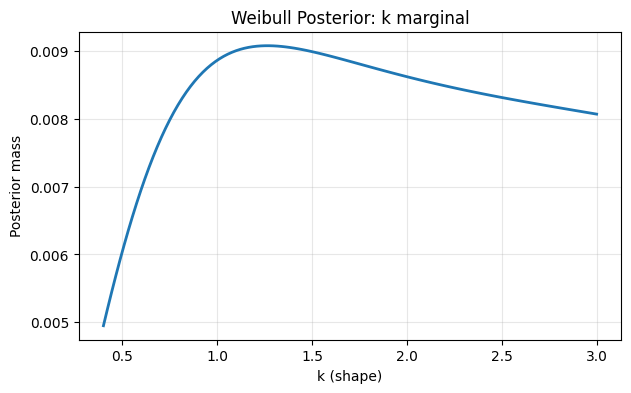

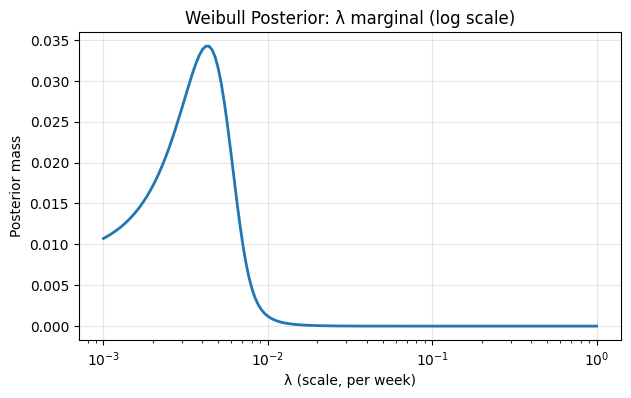

In [38]:
def plot_weibull_marginals(grid: WeibullPosteriorGrid) -> None:
    w = np.exp(grid.log_post)
    w /= w.sum()

    k_marg = w.sum(axis=1)
    lam_marg = w.sum(axis=0)

    plt.figure(figsize=(7, 4))
    plt.plot(grid.k_grid, k_marg, lw=2)
    plt.xlabel("k (shape)")
    plt.ylabel("Posterior mass")
    plt.title("Weibull Posterior: k marginal")
    plt.grid(True, alpha=0.3)
    plt.show()

    plt.figure(figsize=(7, 4))
    plt.plot(grid.lam_grid, lam_marg, lw=2)
    plt.xscale("log")
    plt.xlabel("λ (scale, per week)")
    plt.ylabel("Posterior mass")
    plt.title("Weibull Posterior: λ marginal (log scale)")
    plt.grid(True, alpha=0.3)
    plt.show()


plot_weibull_marginals(wb_post)


## Conditional probability over horizon `h` after `t0` event-free weeks 
Given the weibull probability/distribution -> P(event in [t0, t0+h] | survive to t0) = 1 - S(t0+h)/S(t0)
where S(t) = exp(-(λ t)^k). We compute the posterior predictive via grid averaging.
* Note: numerically stable Weibull predictive (avoids divide-by-zero / underflow) so we have patched this
* Uses: 1 - exp(-Δ), where Δ = (λ(t0+h))^k - (λ t0)^k. Also clips to [0, 1].

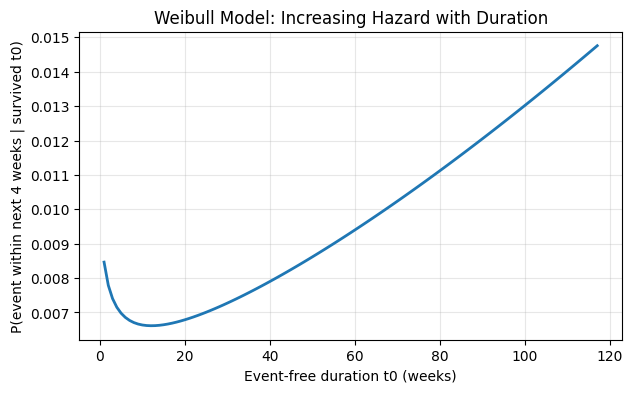

In [40]:
def weibull_predictive_prob(grid: WeibullPosteriorGrid, t0: float, h: float) -> float:
    """
    Posterior predictive P(event in [t0, t0+h] | survive to t0) under Weibull,
    computed in a numerically stable way:
        1 - exp(-Δ), where Δ = (λ(t0+h))^k - (λ t0)^k.

    Parameters
    ----------
    grid : WeibullPosteriorGrid
        Posterior grid over k and λ with log_post weights.
    t0 : float
        Event-free duration up to 'now' (weeks).
    h : float
        Horizon length (weeks).

    Returns
    -------
    float
        Posterior predictive probability in [0, 1].
    """
    w = np.exp(grid.log_post)
    w /= w.sum()

    k = grid.k_grid[:, None]         # shape (K, 1)
    lam = grid.lam_grid[None, :]     # shape (1, L)

    # Compute Δ = (λ(t0+h))^k - (λ t0)^k directly (no division of survivals).
    # Guard against tiny negative Δ from round-off with np.maximum(., 0).
    term_future = np.power(lam * (t0 + h), k)
    term_now = np.power(lam * t0, k)
    delta = np.maximum(term_future - term_now, 0.0)

    # Stable transform: 1 - exp(-Δ). For very small Δ, use -expm1(-Δ) to preserve precision.
    cond = -np.expm1(-delta)

    # Numerical safety: confine to [0, 1].
    cond = np.clip(cond, 0.0, 1.0)

    # Posterior average over the grid.
    return float((w * cond).sum())


def plot_weibull_conditional_curve(
    grid: WeibullPosteriorGrid, t0_max: int = 52, h: int = 4
) -> None:
    t_vals = np.arange(1, t0_max + 1, dtype=float)
    probs = np.array([weibull_predictive_prob(grid, t0=t, h=float(h)) for t in t_vals])

    plt.figure(figsize=(7, 4))
    plt.plot(t_vals, probs, lw=2)
    plt.xlabel("Event-free duration t0 (weeks)")
    plt.ylabel(f"P(event within next {h} weeks | survived t0)")
    plt.title("Weibull Model: Increasing Hazard with Duration")
    plt.grid(True, alpha=0.3)
    plt.show()


# Use last ongoing spell (if any) as current t0
t0_current = dur.censored or 1.0
plot_weibull_conditional_curve(wb_post, t0_max=int(max(12, t0_current)), h=4)


Now we want to compare both models we have created (using the exponential gamma distribution and weibull distribution)

In [41]:
def walk_forward_probabilities(
    event_series: pd.Series, horizon_weeks: int = 4
) -> pd.DataFrame:
    """
    At each week t, compute P(event in next h weeks | survival to t)
    for:
      - Exponential (Gamma posterior)
      - Weibull (grid posterior)
    """
    event_series = event_series.copy().astype(int)
    results = []

    # Exponential prior (fixed once) from initial calibration window (all data up to t)
    for t in range(8, len(event_series)):
        sub = event_series.iloc[: t + 1]
        prior = calibrate_exponential_prior(sub, prior_strength=5.0)
        durs = durations_from_events(sub)
        exp_post = fit_exponential_posterior(sub, prior, durs)
        p_exp = exp_post.prob_event_next_h_weeks(h=float(horizon_weeks))

        wb_post = fit_weibull_grid_posterior(durs, prior_strength=1.0)
        t0 = durs.censored or 1.0
        p_wb = weibull_predictive_prob(wb_post, t0=t0, h=float(horizon_weeks))

        results.append(
            {
                "week_end": sub.index[-1],
                "p_exp_next_h": p_exp,
                "p_wb_next_h": p_wb,
            }
        )

    return pd.DataFrame(results).set_index("week_end")


wf = walk_forward_probabilities(weekly["event"], horizon_weeks=4)
wf.tail()


,p_exp_next_h,p_wb_next_h
week_end,,
2025-09-16,0.047597,0.017839
2025-09-17,0.047503,0.017740
2025-09-18,0.047409,0.017643
2025-09-19,0.047316,0.017547
2025-09-22,0.047223,0.017452


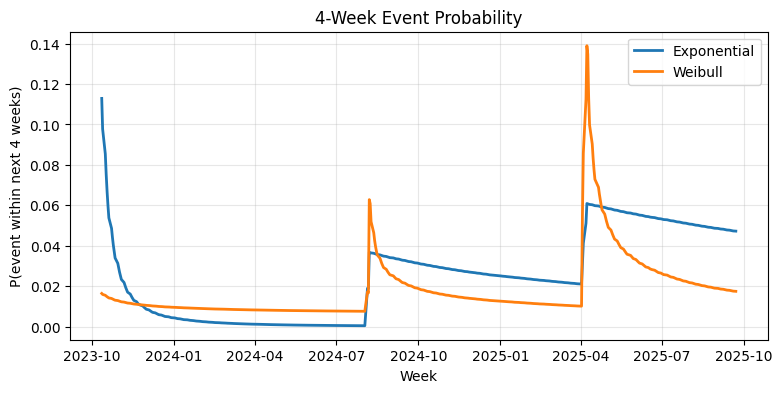

In [42]:
def plot_walk_forward(wf_df: pd.DataFrame, title: str = "4-Week Event Probability") -> None:
    plt.figure(figsize=(9, 4))
    plt.plot(wf_df.index, wf_df["p_exp_next_h"], lw=2, label="Exponential")
    plt.plot(wf_df.index, wf_df["p_wb_next_h"], lw=2, label="Weibull")
    plt.xlabel("Week")
    plt.ylabel("P(event within next 4 weeks)")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()


plot_walk_forward(wf)


Functions to query probability for any horizon h "today".

In [46]:
def probability_next_h_weeks(h: int = 10) -> Dict[str, float]:
    """
    Compute P(event within next h weeks) using current data.
    Returns both Exponential and Weibull model estimates.
    """
    prior = calibrate_exponential_prior(weekly["event"], prior_strength=5.0)
    exp_post_ = fit_exponential_posterior(weekly["event"], prior, dur)
    p_exp = exp_post_.prob_event_next_h_weeks(float(h))

    wb_post_ = fit_weibull_grid_posterior(dur, prior_strength=1.0)
    t0_ = dur.censored or 1.0
    p_wb = weibull_predictive_prob(wb_post_, t0=t0_, h=float(h))

    return {"p_exp": p_exp, "p_weibull": p_wb}


probability_next_h_weeks(50)


{'p_exp': np.float64(0.4393288772862681), 'p_weibull': 0.18419997899320267}